In [1]:
from Utils import normalize_meshId,preprocess_text
from pandas import read_csv
from Data_retrieval import load_dataset
from Evalutation import graphType, model_evaluation, create_knowledge_graph, plot_hist,find_matches_drug_disease
from itertools import product
from tqdm.notebook import tqdm
tqdm.pandas()

%reload_ext autoreload
%autoreload 2

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andrea\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrea\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_texts, df_entities = load_dataset()

df_entities = df_entities[~df_entities['prob'].isna()]
df_entities = df_entities[df_entities['prob'] > 0.8]
df_entities = df_entities[['id', 'pmid', 'mention', 'obj', 'span_begin', 'span_end']]

## Test set creation

To test the knowledge graph is used the SCMFDD dataset, there are three kinds of files: diseases, drugs and diseases-drugs associations.

The dataframe `diseases-drug` associations contains:
- drug_id: id of drug
- drug_name: plain name of drug
- disease_id: id of disease
- disease_name: plain name of disease

In [3]:
SCMFF_DIR = 'dataset/SCMFDD/SCMFDD-L/'

scmff_dda = read_csv(f'{SCMFF_DIR}drug-disease association.csv')
scmff_drugs = read_csv(f'{SCMFF_DIR}drug.csv')
scmff_diseases = read_csv(f'{SCMFF_DIR}disease.csv')

Add column `source` that is `true` for each disease of `df_entities` that is also inside the test set.

In [4]:
scmff_diseases_labels = scmff_diseases['disease_id'].unique()
union_diseases = list(filter(lambda x: normalize_meshId(x) in scmff_diseases_labels,
                             df_entities[df_entities['obj'] == 'disease']['id'].unique()))

df_entities['source'] = (df_entities['obj'] == 'disease') & (df_entities['id'].isin(union_diseases))

sum(df_entities['source'])

64555

In [5]:
scmff_dda['drug_id'] = scmff_dda['drug_id'].apply(normalize_meshId)
scmff_dda['disease_id'] = scmff_dda['disease_id'].apply(normalize_meshId)

normalized_union_diseases = map(normalize_meshId, union_diseases)
scmff_dda = scmff_dda[scmff_dda['disease_id'].isin(normalized_union_diseases)]

In [6]:
test_set = {
    (
        v['drug_id'],
        v['disease_id']
    ): True for v in scmff_dda[['drug_id', 'disease_id']].to_dict(orient='records')
}

In [ ]:
# id_to_wuid = {id: f'unique_{i}' for i, id in enumerate(df_entities['id'].unique())}
# texts = df_texts.progress_apply(preprocess_text(df_entities,id_to_wuid), axis=1).tolist()

In [7]:
coc_configs = dict(
    k=list(range(5, 41, 5))
)

w2v_configs = dict(
    min_count=[2, 5],
    vector_size=[100, 500],
    window=[5, 10],
    sg=[False, True],
    learning_rate=[0.1],
    epochs=[100],
)

configs = [
    *[(graphType.COOCCURRENCES, dict(zip(coc_configs, t))) for t in product(*coc_configs.values())],
    *[(graphType.WORD2VEC, dict(zip(w2v_configs, t))) for t in product(*w2v_configs.values())],
]

In [ ]:
ranking = model_evaluation(configs=configs,
                     ts_set=test_set,
                     texts=texts,
                     df_entities=df_entities,
                     max_diseases=100,
                     top_z=10)

In [ ]:
for precision, config in ranking:
    print(precision, config)

In [8]:
# We found that the best configuration is with Cooncurrences with k = 10
configs[1][1]

{'k': 10}

In [9]:
# precision, config = ranking[1]
graph = create_knowledge_graph(configs[1], df_entities, test_set)

Co_occurrencesGraph populate_adj_matrix: 100%|██████████| 9898/9898 [01:31<00:00, 108.07it/s]


In [13]:
matches = find_matches_drug_disease(graph, top_z=10, test_set=test_set, max_diseases=100)

test_drug_disease: 100%|██████████| 100/100 [03:14<00:00,  1.94s/it]


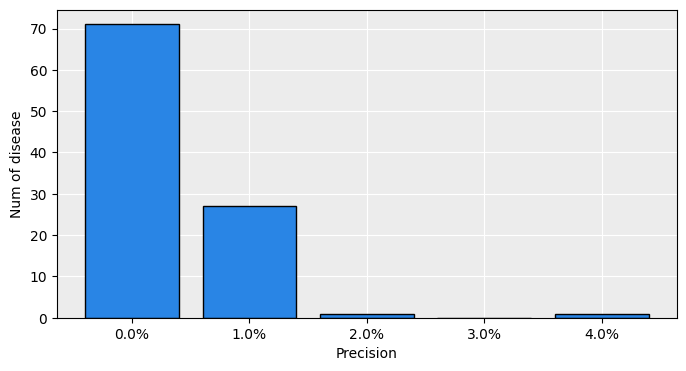

In [14]:
plot_hist(matches)

In [20]:
# import scipy.stats as stats
#
# stats.ttest_ind([1, 5, 8], [10, 5, 8], alternative='greater')[1]

0.8522887784721225

In [ ]:
# disease_drugs = {}
# for (drug, disease), _ in test_set.items():
#     if disease not in disease_drugs:
#         disease_drugs[disease] = [drug]
#     else:
#         disease_drugs[disease].append(drug)
#
# list(disease_drugs.items())[0]

In [ ]:
# def sample_test_drugs_by_disease(disease, k):
#     drug_ids = disease_drugs[normalize_meshid(disease)]
#     samples = sample(drug_ids, k) if k < len(drug_ids) else drug_ids
#     return [normalize_meshid(id) for id in  samples]
#
#
# def sample_drugs(graph: Graph, k):
#     drug_ids = [normalize_meshid(id) for id, info in graph.id_to_info.items() if info['obj'] == 'drug']
#     return sample(drug_ids, k) if k < len(drug_ids) else drug_ids
#
#
# def find_pvalues_drug_disease(graph: Graph, firsts_selected_diseases: int = None, n_samples: int = 15, offset=0):
#     i_diseases = [i_node for _, i_node in GraphRanker(graph).rank_nodes() if graph.index_to_info[i_node]['source']][offset
#                                                                                                                     :firsts_selected_diseases]  # intersection
#     predicate = lambda x: x['obj'] == 'drug'
#     pvalues = []
#
#     for i_disease in tqdm(i_diseases, desc="find_pvalues_drug_disease"):
#         sample_true = sample_test_drugs_by_disease(normalize_meshid(graph.node_ids[i_disease]), n_samples)
#         sample_random = sample_drugs(graph, n_samples)
#
#         storage = set()
#         def stop_condition(x):
#             norm_id = normalize_meshid(x['id'])
#             if norm_id in sample_true or norm_id in sample_random:
#                 storage.add(norm_id)
#             return len(storage) >= len(sample_true) + len(sample_random)
#
#         nearest_neighbors = graph.find_nearest(i_disease, predicate=predicate, max=None, stop_condition=stop_condition)
#         scores_true, scores_random = [], []
#         for rank, (i_neighbor, _, _) in enumerate(nearest_neighbors):
#             id_node = normalize_meshid(graph.node_ids[i_neighbor])
#             if id_node in sample_true:
#                 scores_true.append(rank + 1)
#             if id_node in sample_random:
#                 scores_random.append(rank + 1)
#         pvalue = stats.ttest_ind(scores_true, scores_random).pvalue
#         pvalues.append(0 if np.isnan(pvalue) else pvalue)
#
#     return pvalues

In [ ]:
# pvalues = [*pvalues, *find_pvalues_drug_disease(graph=graph, firsts_selected_diseases=20, n_samples=3, offset=10)]
#
# pvalues

In [ ]:
# plt.bar([str(i) for i, pv in enumerate(pvalues)], pvalues)

In [ ]:
# np.mean(pvalues)

In [ ]:
# i_diseases = [i_node for _, i_node in GraphRanker(graph).rank_nodes() if graph.index_to_info[i_node]['source']][:10]
# for i_disease in tqdm(i_diseases):
#     nearest_neighbors = graph.find_nearest(i_disease, predicate=lambda x: x['obj'] == 'drug', max=10)
#     print(graph.index_to_info[i_disease]["mention"])
#     for rank, (i_neighbor, history, cost) in enumerate(nearest_neighbors):
#         print(f'\t{rank}: {graph.index_to_info[i_neighbor]["mention"]} ({cost})')